### All Imports and Setup

In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [73]:
# Set random seed for reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    print("Using GPU")
    torch.cuda.manual_seed_all(SEED)

### Custom Moons

In [74]:
def custom_moons(n, noise):
    n_per_moon = n // 2
   
    # Generate the bottom moon (label 0)
    t0 = np.linspace(0, np.pi, n_per_moon)
    x0 = 1 - np.cos(t0)
    y0 = 0.5 - np.sin(t0)
    
    # Generate the top moon (label 1)
    t1 = np.linspace(0, np.pi, n_per_moon)
    x1 = 1 * np.cos(t1)
    y1 = 1 * np.sin(t1)
    
    # Combine moons
    X = np.vstack([np.column_stack([x1, y1]),
                   np.column_stack([x0, y0])])
    y = np.hstack([np.ones(n_per_moon), 
                   np.zeros(n_per_moon)])
    
    # Add noise
    noise = np.random.normal(0, noise, X.shape)
    X_noisy = X + noise
    
    # Shuffle the dataset
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    return X_noisy[indices], y[indices]


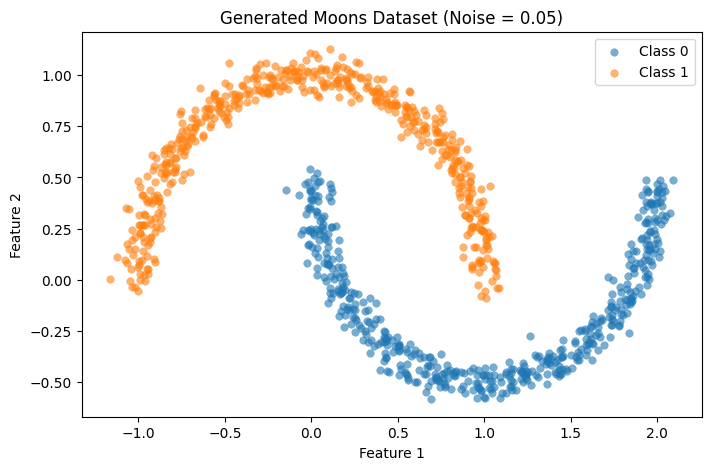

In [75]:
# Common scatter settings
scatter_kwargs = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)

# Example usage
X, y = custom_moons(1000, noise=0.05)
# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X[y==0, 0], X[y==0, 1], label="Class 0", alpha=0.6, s=30, linewidths=0.3)
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class 1", alpha=0.6, s=30, linewidths=0.3)
plt.title("Generated Moons Dataset (Noise = 0.05)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### Generating Datasets

Train/Val set shape: (500, 2)
Test set (noise 0.1) shape: (500, 2)
Test set (noise 0.2) shape: (500, 2)
Test set (noise 0.3) shape: (500, 2)


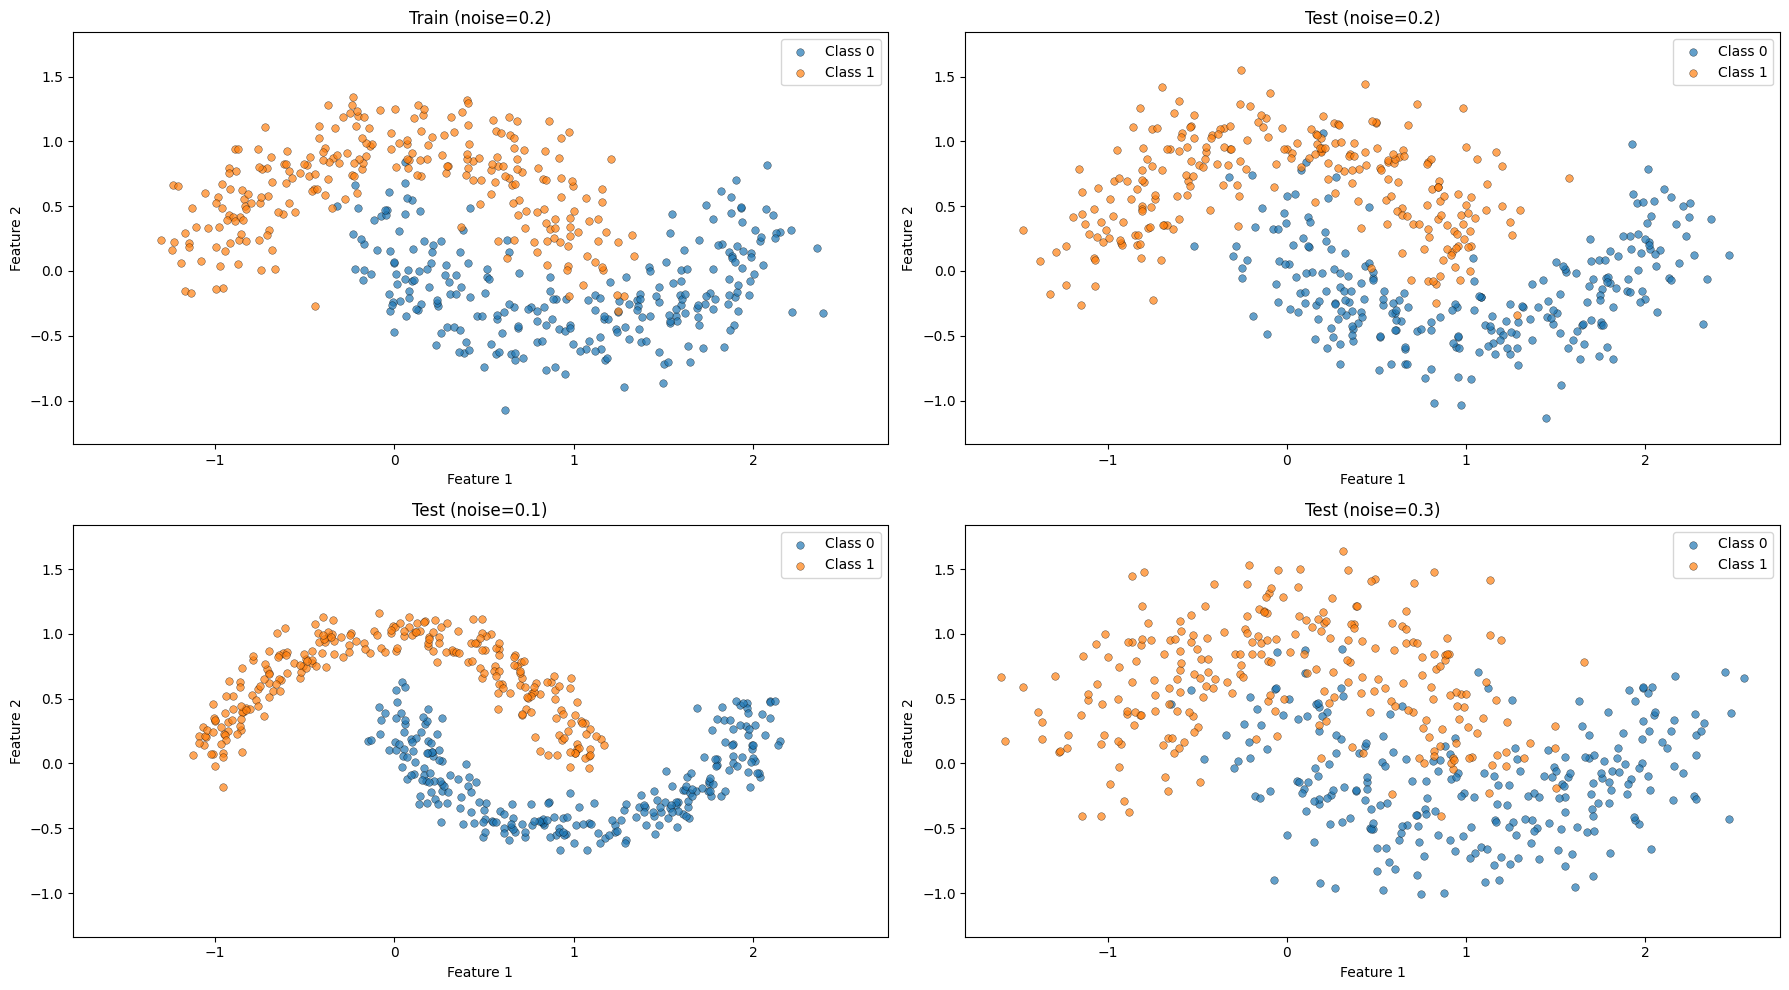

In [76]:
# Generate the datasets
X_train_full, y_train_full = custom_moons(n=500, noise=0.2)
X_test_01, y_test_01 = custom_moons(n=500, noise=0.1)
X_test_02, y_test_02 = custom_moons(n=500, noise=0.2)
X_test_03, y_test_03 = custom_moons(n=500, noise=0.3)

print(f"Train/Val set shape: {X_train_full.shape}")
print(f"Test set (noise 0.1) shape: {X_test_01.shape}")
print(f"Test set (noise 0.2) shape: {X_test_02.shape}")
print(f"Test set (noise 0.3) shape: {X_test_03.shape}")

# Visualize Train and both Test sets side-by-side
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Determine consistent axis limits for better comparison
all_X = np.vstack([X_train_full, X_test_01, X_test_02, X_test_03])
xmin, ymin = all_X.min(axis=0) - 0.2
xmax, ymax = all_X.max(axis=0) + 0.2

# Train
axes[0][0].scatter(X_train_full[y_train_full==0, 0], X_train_full[y_train_full==0, 1], label='Class 0', **scatter_kwargs)
axes[0][0].scatter(X_train_full[y_train_full==1, 0], X_train_full[y_train_full==1, 1], label='Class 1', **scatter_kwargs)
axes[0][0].set_title('Train (noise=0.2)')
axes[0][0].set_xlim(xmin, xmax)
axes[0][0].set_ylim(ymin, ymax)
axes[0][0].set_xlabel('Feature 1')
axes[0][0].set_ylabel('Feature 2')
axes[0][0].legend()

# Test noise=0.1
axes[1][0].scatter(X_test_01[y_test_01==0, 0], X_test_01[y_test_01==0, 1], label='Class 0', **scatter_kwargs)
axes[1][0].scatter(X_test_01[y_test_01==1, 0], X_test_01[y_test_01==1, 1], label='Class 1', **scatter_kwargs)
axes[1][0].set_title('Test (noise=0.1)')
axes[1][0].set_xlim(xmin, xmax)
axes[1][0].set_ylim(ymin, ymax)
axes[1][0].set_xlabel('Feature 1')
axes[1][0].set_ylabel('Feature 2')
axes[1][0].legend()

axes[0][1].scatter(X_test_02[y_test_02==0, 0], X_test_02[y_test_02==0, 1], label='Class 0', **scatter_kwargs)
axes[0][1].scatter(X_test_02[y_test_02==1, 0], X_test_02[y_test_02==1, 1], label='Class 1', **scatter_kwargs)
axes[0][1].set_title('Test (noise=0.2)')
axes[0][1].set_xlim(xmin, xmax)
axes[0][1].set_ylim(ymin, ymax)
axes[0][1].set_xlabel('Feature 1')
axes[0][1].set_ylabel('Feature 2')
axes[0][1].legend()

# Test noise=0.3
axes[1][1].scatter(X_test_03[y_test_03==0, 0], X_test_03[y_test_03==0, 1], label='Class 0', **scatter_kwargs)
axes[1][1].scatter(X_test_03[y_test_03==1, 0], X_test_03[y_test_03==1, 1], label='Class 1', **scatter_kwargs)
axes[1][1].set_title('Test (noise=0.3)')
axes[1][1].set_xlim(xmin, xmax)
axes[1][1].set_ylim(ymin, ymax)
axes[1][1].set_xlabel('Feature 1')
axes[1][1].set_ylabel('Feature 2')
axes[1][1].legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

In [77]:
# Create validation split (20% of the 500 points)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    stratify=y_train_full #ensures class balance in split
)

print(f"Final training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Final training set shape: (400, 2)
Validation set shape: (100, 2)


In [78]:
# Standardize x using train statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit ONLY on X_train

# Transform all other sets
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

# Convert to PyTorch Tensors
# We need y to be (batch_size, 1) and float for BinaryCrossEntropyWithLogitsLoss
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_train_full_t = torch.tensor(X_train_full_scaled, dtype=torch.float32)
y_train_full_t = torch.tensor(y_train_full, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32)
y_test_01_t = torch.tensor(y_test_01, dtype=torch.float32).view(-1, 1)

X_test_02_t = torch.tensor(X_test_02_scaled, dtype=torch.float32)
y_test_02_t = torch.tensor(y_test_02, dtype=torch.float32).view(-1, 1)

X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32)
y_test_03_t = torch.tensor(y_test_03, dtype=torch.float32).view(-1, 1)

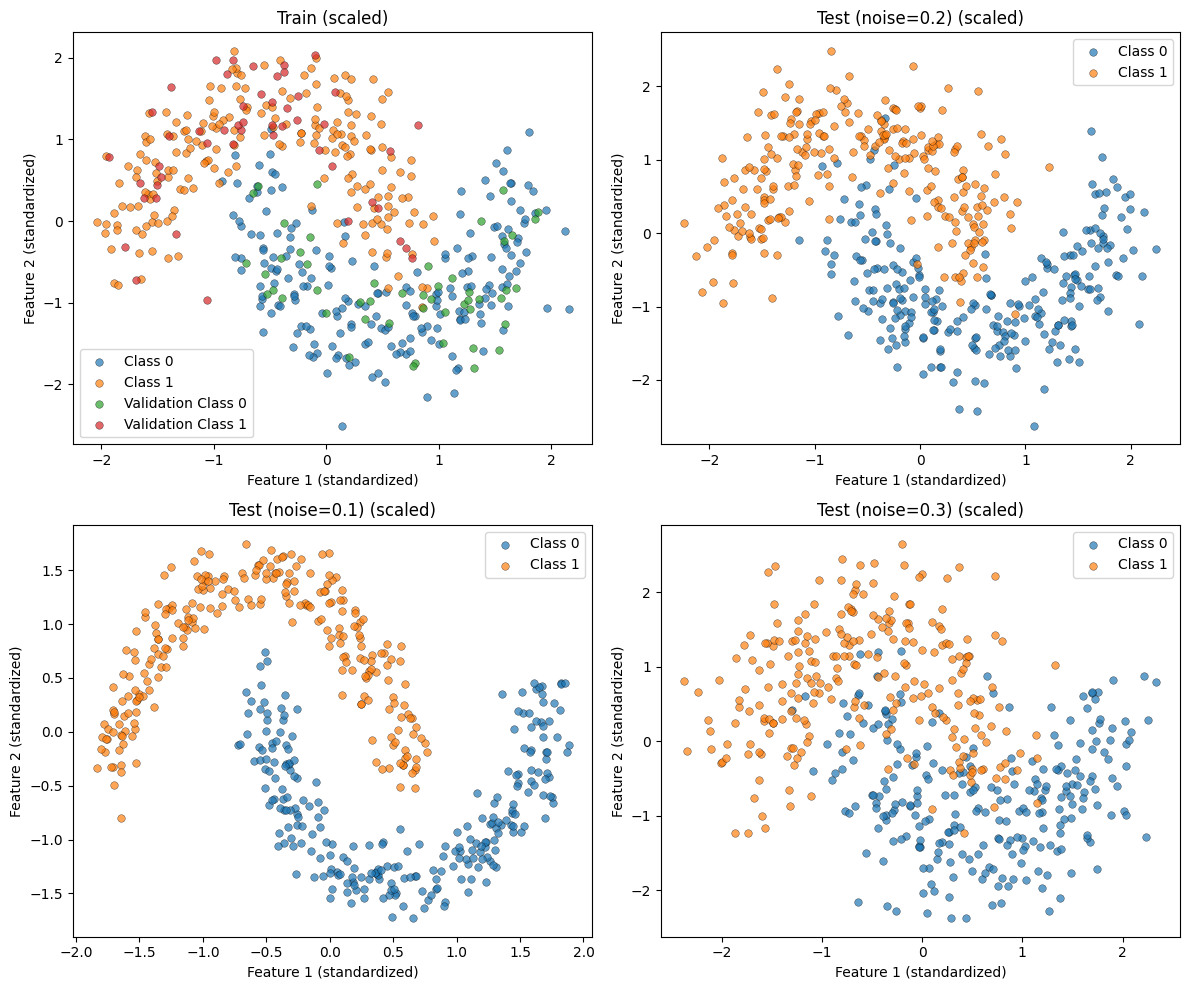

In [79]:
# Visualize the SCALED datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Use same scatter settings as before
scatter_kwargs_scaled = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)

# Train (scaled)
axes[0][0].scatter(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1], label='Class 0', **scatter_kwargs_scaled)
axes[0][0].scatter(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1], label='Class 1', **scatter_kwargs_scaled)
axes[0][0].scatter(X_val_scaled[y_val==0, 0], X_val_scaled[y_val==0, 1], label='Validation Class 0', **scatter_kwargs_scaled)
axes[0][0].scatter(X_val_scaled[y_val==1, 0], X_val_scaled[y_val==1, 1], label='Validation Class 1', **scatter_kwargs_scaled)
axes[0][0].set_title('Train (scaled)')
axes[0][0].set_xlabel('Feature 1 (standardized)')
axes[0][0].set_ylabel('Feature 2 (standardized)')
axes[0][0].legend()

# Test (scaled)
axes[0][1].scatter(X_test_02_scaled[y_test_02==0, 0], X_test_02_scaled[y_test_02==0, 1], label='Class 0', **scatter_kwargs_scaled)
axes[0][1].scatter(X_test_02_scaled[y_test_02==1, 0], X_test_02_scaled[y_test_02==1, 1], label='Class 1', **scatter_kwargs_scaled)
axes[0][1].set_title('Test (noise=0.2) (scaled)')
axes[0][1].set_xlabel('Feature 1 (standardized)')
axes[0][1].set_ylabel('Feature 2 (standardized)')
axes[0][1].legend()

# Test noise=0.1 (scaled)
axes[1][0].scatter(X_test_01_scaled[y_test_01==0, 0], X_test_01_scaled[y_test_01==0, 1], label='Class 0', **scatter_kwargs_scaled)
axes[1][0].scatter(X_test_01_scaled[y_test_01==1, 0], X_test_01_scaled[y_test_01==1, 1], label='Class 1', **scatter_kwargs_scaled)
axes[1][0].set_title('Test (noise=0.1) (scaled)')
axes[1][0].set_xlabel('Feature 1 (standardized)')
axes[1][0].set_ylabel('Feature 2 (standardized)')
axes[1][0].legend()

# Test noise=0.3 (scaled)
axes[1][1].scatter(X_test_03_scaled[y_test_03==0, 0], X_test_03_scaled[y_test_03==0, 1], label='Class 0', **scatter_kwargs_scaled)
axes[1][1].scatter(X_test_03_scaled[y_test_03==1, 0], X_test_03_scaled[y_test_03==1, 1], label='Class 1', **scatter_kwargs_scaled)
axes[1][1].set_title('Test (noise=0.3) (scaled)')
axes[1][1].set_xlabel('Feature 1 (standardized)')
axes[1][1].set_ylabel('Feature 2 (standardized)')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [80]:
# Define the MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=1):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x) # No sigmoid, as we'll use BCEWithLogitsLoss
        return x

# Utility for AUROC
def get_auroc(model, X, y):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        return roc_auc_score(y.numpy(), probs.numpy())

# Generalized Training Loop
def train_network(model, X_train, y_train, X_val, y_val, 
                  optimizer, criterion, 
                  n_epochs=1000, 
                  early_stopping_patience=None,
                  l1_lambda=0.0):
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(n_epochs):
        model.train() # Set model to training mode
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Add L1 penalty if applicable
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation check
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            
        # Early Stopping logic
        if early_stopping_patience:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict() # Save the best model
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve == early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state) # Restore best model
                break
    
    if early_stopping_patience and best_model_state:
        model.load_state_dict(best_model_state) # Ensure best model is loaded

### MLP with Early Stopping

In [81]:
print("\n--- Training Model 1: MLP + Early Stopping ---")
model_es = SimpleMLP()
optimizer_es = optim.Adam(model_es.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

train_network(
    model=model_es,
    X_train=X_train_t, y_train=y_train_t,
    X_val=X_val_t, y_val=y_val_t,
    optimizer=optimizer_es,
    criterion=criterion,
    n_epochs=2000,
    early_stopping_patience=50
)

# Report robustness
auroc_es_val = get_auroc(model_es, X_val_t, y_val_t)
auroc_es_test1 = get_auroc(model_es, X_test_01_t, y_test_01_t)
auroc_es_test2 = get_auroc(model_es, X_test_02_t, y_test_02_t)
auroc_es_test3 = get_auroc(model_es, X_test_03_t, y_test_03_t)

print(f"Validation AUROC: {auroc_es_val:.4f}")
print(f"Test (noise 0.1) AUROC: {auroc_es_test1:.4f}")
print(f"Test (noise 0.2) AUROC: {auroc_es_test2:.4f}")
print(f"Test (noise 0.3) AUROC: {auroc_es_test2:.4f}")


--- Training Model 1: MLP + Early Stopping ---
Early stopping at epoch 198
Validation AUROC: 0.9936
Test (noise 0.1) AUROC: 1.0000
Test (noise 0.2) AUROC: 0.9919
Test (noise 0.3) AUROC: 0.9919


### MLP + L1 Regularization


--- Training Model 2: MLP + L1 Regularization ---
Validation AUROC with L1 lambda 1e-06: 0.9940
Validation AUROC with L1 lambda 1e-06: 0.9940
Validation AUROC with L1 lambda 3e-06: 0.9920
Validation AUROC with L1 lambda 3e-06: 0.9920
Validation AUROC with L1 lambda 1e-05: 0.9884
Validation AUROC with L1 lambda 1e-05: 0.9884
Validation AUROC with L1 lambda 3e-05: 0.9932
Validation AUROC with L1 lambda 3e-05: 0.9932
Validation AUROC with L1 lambda 0.0001: 0.9912
Validation AUROC with L1 lambda 0.0001: 0.9912
Validation AUROC with L1 lambda 0.0003: 0.9916
Validation AUROC with L1 lambda 0.0003: 0.9916


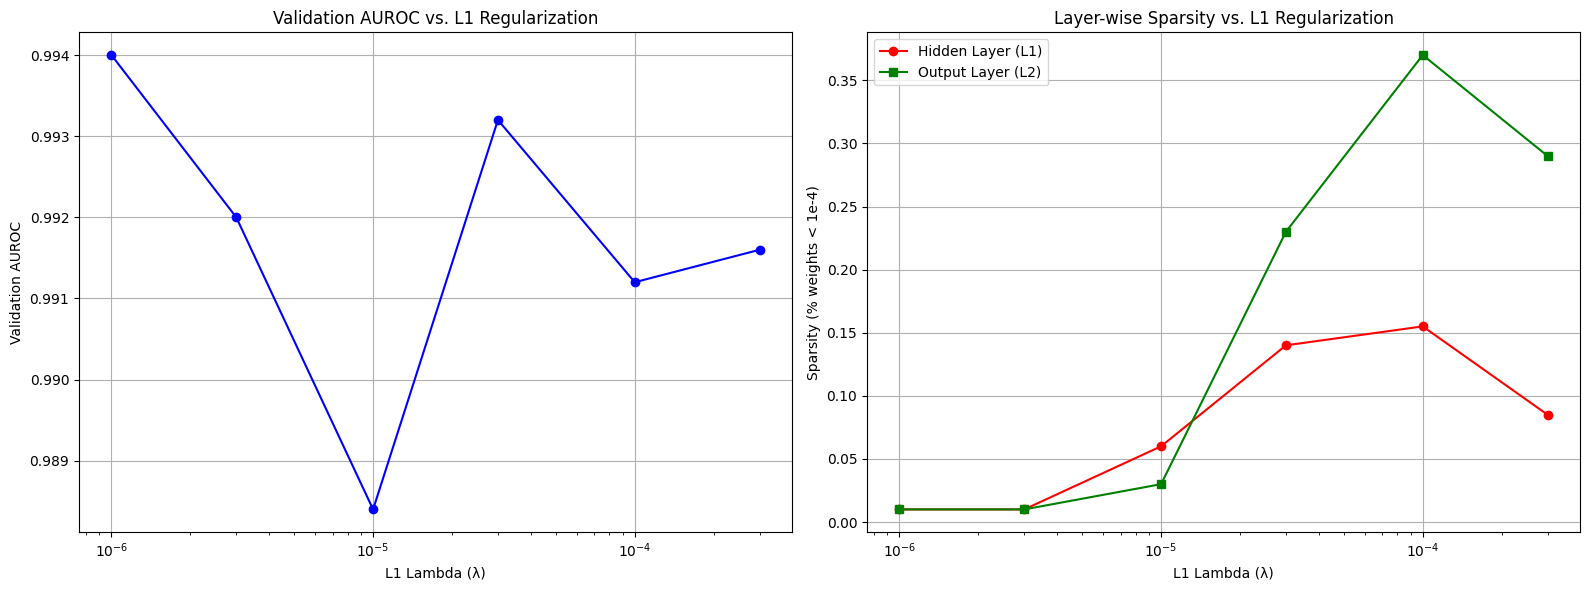

Best L1 Lambda based on Validation AUROC: 1e-06


In [82]:
print("\n--- Training Model 2: MLP + L1 Regularization ---")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs_l1 = []
sparsity_l1 = [] # Layer 1 sparsity
sparsity_l2 = [] # Layer 2 sparsity
best_l1_model = None
best_l1_auroc = -1
best_l1_lambda = None

SPARSITY_THRESHOLD = 1e-4

for lam in l1_lambdas:
    model_l1 = SimpleMLP()
    optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.01) 
    criterion = nn.BCEWithLogitsLoss()
    
    # print(f"Training with L1 lambda = {lam}")
    train_network(
        model=model_l1,
        X_train=X_train_t, y_train=y_train_t,
        X_val=X_val_t, y_val=y_val_t,
        optimizer=optimizer_l1,
        criterion=criterion,
        n_epochs=2000, # Fixed epochs for comparison
        l1_lambda=lam
    )
    
    # Report Validation AUROC
    val_auroc = get_auroc(model_l1, X_val_t, y_val_t)
    print(f"Validation AUROC with L1 lambda {lam}: {val_auroc:.4f}")
    val_aurocs_l1.append(val_auroc)

    if val_auroc > best_l1_auroc:
        best_l1_auroc = val_auroc
        best_l1_model = model_l1 # Save the model object
        best_l1_lambda = lam

    # Report Layer-wise Sparsity
    l1_weights = model_l1.layer1.weight.data
    l2_weights = model_l1.layer2.weight.data
    
    sp1 = (l1_weights.abs() < SPARSITY_THRESHOLD).float().mean().item()
    sp2 = (l2_weights.abs() < SPARSITY_THRESHOLD).float().mean().item()
    
    sparsity_l1.append(sp1)
    sparsity_l2.append(sp2)

# Plotting the results for L1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Validation AUROC vs. Lambda
ax1.plot(l1_lambdas, val_aurocs_l1, 'bo-')
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC')
ax1.set_title('Validation AUROC vs. L1 Regularization')
ax1.grid(True)


# Plot Sparsity vs. Lambda
ax2.plot(l1_lambdas, sparsity_l1, 'ro-', label='Hidden Layer (L1)')
ax2.plot(l1_lambdas, sparsity_l2, 'gs-', label='Output Layer (L2)')
ax2.set_xscale('log')
ax2.set_xlabel('L1 Lambda (λ)')
ax2.set_ylabel('Sparsity (% weights < 1e-4)')
ax2.set_title('Layer-wise Sparsity vs. L1 Regularization')
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.show()

# Find the best L1 model and report test scores
best_l1_idx = np.argmax(val_aurocs_l1)
best_l1_lambda = l1_lambdas[best_l1_idx]
print(f"Best L1 Lambda based on Validation AUROC: {best_l1_lambda}")
# (You would typically retrain the model with this lambda, but for this exercise,
# we can use the one from the loop)

In [83]:
# Get test scores for the best L1 model
auroc_l1_test1 = get_auroc(best_l1_model, X_test_01_t, y_test_01_t)
auroc_l1_test2 = get_auroc(best_l1_model, X_test_02_t, y_test_02_t)
auroc_l1_test3 = get_auroc(best_l1_model, X_test_03_t, y_test_03_t)

print(f"Best L1 Model - Test (noise 0.1) AUROC: {auroc_l1_test1:.4f}")
print(f"Best L1 Model - Test (noise 0.2) AUROC: {auroc_l1_test2:.4f}")
print(f"Best L1 Model - Test (noise 0.3) AUROC: {auroc_l1_test3:.4f}")

Best L1 Model - Test (noise 0.1) AUROC: 1.0000
Best L1 Model - Test (noise 0.2) AUROC: 0.9920
Best L1 Model - Test (noise 0.3) AUROC: 0.9633


### MLP + L2 Regularization


--- Training Model 3: MLP + L2 Regularization ---
Validation AUROC with L2 alpha 1e-06: 0.9948
Validation AUROC with L2 alpha 1e-06: 0.9948
Validation AUROC with L2 alpha 3e-06: 0.9808
Validation AUROC with L2 alpha 3e-06: 0.9808
Validation AUROC with L2 alpha 1e-05: 0.9940
Validation AUROC with L2 alpha 1e-05: 0.9940
Validation AUROC with L2 alpha 3e-05: 0.9848
Validation AUROC with L2 alpha 3e-05: 0.9848
Validation AUROC with L2 alpha 0.0001: 0.9952
Validation AUROC with L2 alpha 0.0001: 0.9952
Validation AUROC with L2 alpha 0.0003: 0.9940
Best L2 alpha (weight_decay): 0.0001 with Val AUROC: 0.9952
Best L2 Model - Test (noise 0.1) AUROC: 1.0000
Best L2 Model - Test (noise 0.2) AUROC: 0.9923
Best L2 Model - Test (noise 0.3) AUROC: 0.9636
Validation AUROC with L2 alpha 0.0003: 0.9940
Best L2 alpha (weight_decay): 0.0001 with Val AUROC: 0.9952
Best L2 Model - Test (noise 0.1) AUROC: 1.0000
Best L2 Model - Test (noise 0.2) AUROC: 0.9923
Best L2 Model - Test (noise 0.3) AUROC: 0.9636


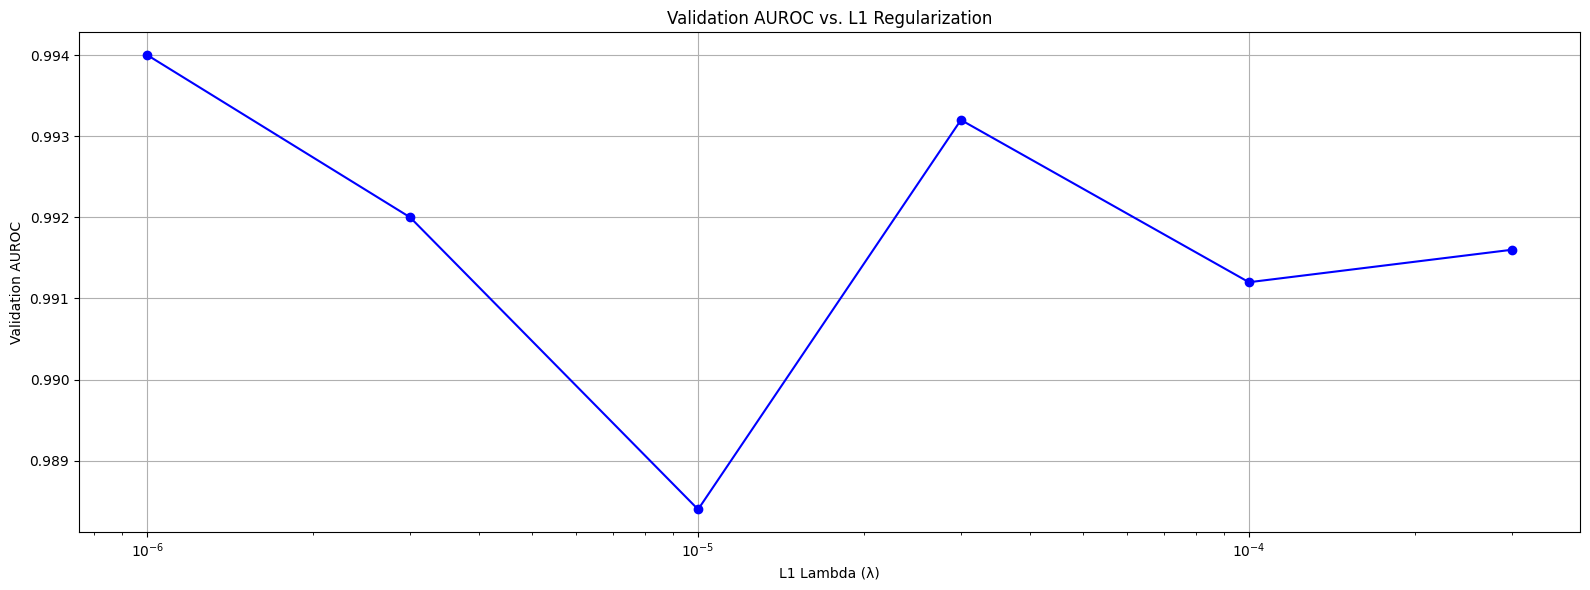

In [84]:
print("\n--- Training Model 3: MLP + L2 Regularization ---")
# L2 grid for weight_decay
l2_alphas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs_l2 = []
best_l2_model = None
best_l2_auroc = -1
best_l2_alpha = None

for alpha in l2_alphas:
    model_l2 = SimpleMLP()
    # Add L2 penalty via weight_decay
    optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.01, weight_decay=alpha)
    criterion = nn.BCEWithLogitsLoss()
    
    # print(f"Training with L2 alpha = {alpha}")
    # Use early stopping to find the best model for this alpha
    train_network(
        model=model_l2,
        X_train=X_train_t, y_train=y_train_t,
        X_val=X_val_t, y_val=y_val_t,
        optimizer=optimizer_l2,
        criterion=criterion,
        n_epochs=2000
    )
    
    val_auroc = get_auroc(model_l2, X_val_t, y_val_t)
    print(f"Validation AUROC with L2 alpha {alpha}: {val_auroc:.4f}")
    val_aurocs_l2.append(val_auroc)
    
    if val_auroc > best_l2_auroc:
        best_l2_auroc = val_auroc
        best_l2_model = model_l2 # Save the model object
        best_l2_alpha = alpha

print(f"Best L2 alpha (weight_decay): {best_l2_alpha} with Val AUROC: {best_l2_auroc:.4f}")

# Report robustness of the best L2 model
auroc_l2_test1 = get_auroc(best_l2_model, X_test_01_t, y_test_01_t)
auroc_l2_test2 = get_auroc(best_l2_model, X_test_02_t, y_test_02_t)
auroc_l2_test3 = get_auroc(best_l2_model, X_test_03_t, y_test_03_t)
print(f"Best L2 Model - Test (noise 0.1) AUROC: {auroc_l2_test1:.4f}")
print(f"Best L2 Model - Test (noise 0.2) AUROC: {auroc_l2_test2:.4f}")
print(f"Best L2 Model - Test (noise 0.3) AUROC: {auroc_l2_test3:.4f}")

# Plotting the results for L1
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))

# Plot Validation AUROC vs. Lambda
ax1.plot(l1_lambdas, val_aurocs_l1, 'bo-')
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC')
ax1.set_title('Validation AUROC vs. L1 Regularization')
ax1.grid(True)


plt.tight_layout()
plt.show()

### Logistic Regression with Polynomial Fetures

In [85]:
print("\n--- Training Model 4: Logistic Regression + Polynomial Features ---")

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=3)

# Fit on the scaled training data
X_train_poly = poly.fit_transform(X_train_scaled)

# Transform all other sets
X_val_poly = poly.transform(X_val_scaled)
X_test_01_poly = poly.transform(X_test_01_scaled)
X_test_02_poly = poly.transform(X_test_02_scaled)
X_test_03_poly = poly.transform(X_test_03_scaled)

# Features will be [x1, x2, x1^2, x1*x2, x2^2]
print(f"Polynomial feature names: {poly.get_feature_names_out(['x1', 'x2'])}")
print(f"New training data shape: {X_train_poly.shape}")

log_reg = LogisticRegression(random_state=SEED, max_iter=1000)
log_reg.fit(X_train_poly, y_train)

# Get probabilities for validation set
y_val_probs = log_reg.predict_proba(X_val_poly)[:, 1]
val_auroc = roc_auc_score(y_val, y_val_probs)


print(f"Val AUROC: {val_auroc:.4f}")

# Report
y_test_01_probs = log_reg.predict_proba(X_test_01_poly)[:, 1]
y_test_02_probs = log_reg.predict_proba(X_test_02_poly)[:, 1]
y_test_03_probs = log_reg.predict_proba(X_test_03_poly)[:, 1]

auroc_lr_test1 = roc_auc_score(y_test_01, y_test_01_probs)
auroc_lr_test2 = roc_auc_score(y_test_02, y_test_02_probs)
auroc_lr_test3 = roc_auc_score(y_test_03, y_test_03_probs)

print(f"LogReg Poly - Test (noise 0.1) AUROC: {auroc_lr_test1:.4f}")
print(f"LogReg Poly - Test (noise 0.2) AUROC: {auroc_lr_test2:.4f}")
print(f"LogReg Poly - Test (noise 0.3) AUROC: {auroc_lr_test3:.4f}")


--- Training Model 4: Logistic Regression + Polynomial Features ---
Polynomial feature names: ['1' 'x1' 'x2' 'x1^2' 'x1 x2' 'x2^2' 'x1^3' 'x1^2 x2' 'x1 x2^2' 'x2^3']
New training data shape: (400, 10)
Val AUROC: 0.9896
LogReg Poly - Test (noise 0.1) AUROC: 1.0000
LogReg Poly - Test (noise 0.2) AUROC: 0.9890
LogReg Poly - Test (noise 0.3) AUROC: 0.9671


In [86]:
# Find the best lambda from our grid search
best_l1_idx = np.argmax(val_aurocs_l1)
best_l1_lambda = l1_lambdas[best_l1_idx]
# The best validation score is already known:
auroc_l1_val = val_aurocs_l1[best_l1_idx]

print(f"\n--- Finalizing Model 2 (L1) ---")
print(f"Best L1 Lambda found: {best_l1_lambda}")
print(f"Best L1 Validation AUROC: {auroc_l1_val:.4f}")

# Retrain the best L1 model (using early stopping for a robust result)
model_l1_best = SimpleMLP()
optimizer_l1_best = optim.Adam(model_l1_best.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

train_network(
    model=model_l1_best,
    X_train=X_train_t, y_train=y_train_t,
    X_val=X_val_t, y_val=y_val_t,
    optimizer=optimizer_l1_best,
    criterion=criterion,
    n_epochs=2000,
    early_stopping_patience=50, # Use early stopping for the final model
    l1_lambda=best_l1_lambda
)

# Get test scores for the best L1 model
auroc_l1_test1 = get_auroc(model_l1_best, X_test_01_t, y_test_01_t)
auroc_l1_test2 = get_auroc(model_l1_best, X_test_02_t, y_test_02_t)
auroc_l1_test3 = get_auroc(model_l1_best, X_test_03_t, y_test_03_t)

print(f"Best L1 Model - Test (noise 0.1) AUROC: {auroc_l1_test1:.4f}")
print(f"Best L1 Model - Test (noise 0.2) AUROC: {auroc_l1_test2:.4f}")
print(f"Best L1 Model - Test (noise 0.3) AUROC: {auroc_l1_test3:.4f}")

# Create a dictionary to hold all the results
report_data = {
    "Validation AUROC (noise 0.2)": {
        "1. MLP + Early Stopping": auroc_es_val,
        "2. MLP + L1": auroc_l1_val,
        "3. MLP + L2": best_l2_auroc,
        "4. LogReg + PolyFeat": val_auroc,
    },
    "Test AUROC (noise 0.1)": {
        "1. MLP + Early Stopping": auroc_es_test1,
        "2. MLP + L1": auroc_l1_test1,
        "3. MLP + L2": auroc_l2_test1,
        "4. LogReg + PolyFeat": auroc_lr_test1,
    },
    "Test AUROC (noise 0.3)": {
        "1. MLP + Early Stopping": auroc_es_test2,
        "2. MLP + L1": auroc_l1_test2,
        "3. MLP + L2": auroc_l2_test2,
        "4. LogReg + PolyFeat": auroc_lr_test2,
    }
}

# print
from IPython.display import Markdown, display
report_df = pd.DataFrame(report_data)
pd.set_option('display.float_format', '{:.4f}'.format)
display(Markdown(report_df.to_markdown(floatfmt=".4f")))


--- Finalizing Model 2 (L1) ---
Best L1 Lambda found: 1e-06
Best L1 Validation AUROC: 0.9940
Early stopping at epoch 189
Best L1 Model - Test (noise 0.1) AUROC: 1.0000
Best L1 Model - Test (noise 0.2) AUROC: 0.9916
Best L1 Model - Test (noise 0.3) AUROC: 0.9626
Early stopping at epoch 189
Best L1 Model - Test (noise 0.1) AUROC: 1.0000
Best L1 Model - Test (noise 0.2) AUROC: 0.9916
Best L1 Model - Test (noise 0.3) AUROC: 0.9626


|                         |   Validation AUROC (noise 0.2) |   Test AUROC (noise 0.1) |   Test AUROC (noise 0.3) |
|:------------------------|-------------------------------:|-------------------------:|-------------------------:|
| 1. MLP + Early Stopping |                         0.9936 |                   1.0000 |                   0.9919 |
| 2. MLP + L1             |                         0.9940 |                   1.0000 |                   0.9916 |
| 3. MLP + L2             |                         0.9952 |                   1.0000 |                   0.9923 |
| 4. LogReg + PolyFeat    |                         0.9896 |                   1.0000 |                   0.9890 |

### Generic Visualization Code

In [87]:
# Visualize decision boundaries for all 4 models on test data (noise 0.2)
def plot_decision_boundary_pytorch(model, X, y, title, ax):
    """Plot decision boundary for PyTorch MLP models."""
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Prepare grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Get predictions from PyTorch model
    model.eval()
    with torch.no_grad():
        grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
        logits = model(grid_tensor)
        Z = torch.sigmoid(logits).numpy().ravel()
    
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and decision regions
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    scatter_kwargs = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', **scatter_kwargs)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', **scatter_kwargs)
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1 (standardized)')
    ax.set_ylabel('Feature 2 (standardized)')
    ax.legend()

def plot_decision_boundary_sklearn(model, X, y, title, ax, poly_transformer):
    """Plot decision boundary for sklearn Logistic Regression with polynomial features."""
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Prepare grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Transform grid points with polynomial features
    grid_points_poly = poly_transformer.transform(grid_points)
    Z = model.predict_proba(grid_points_poly)[:, 1]
    
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and decision regions
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    scatter_kwargs = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', **scatter_kwargs)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', **scatter_kwargs)
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1 (standardized)')
    ax.set_ylabel('Feature 2 (standardized)')
    ax.legend()
    
    return contour


### Visuls in our data

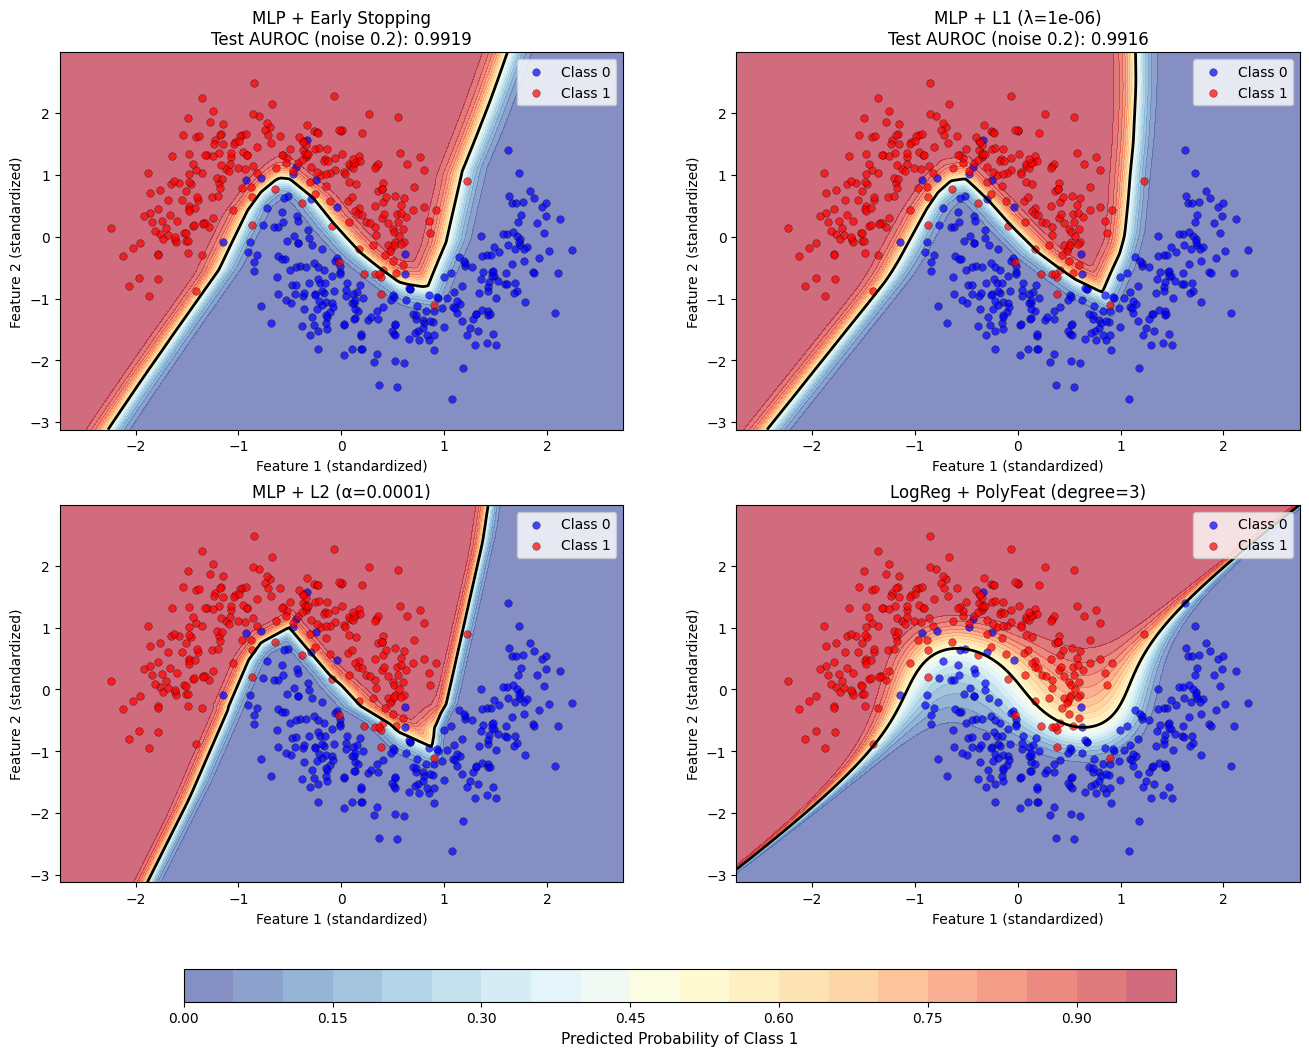

In [88]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Model 1: MLP + Early Stopping
plot_decision_boundary_pytorch(
    model_es, X_test_02_scaled, y_test_02,
    f'MLP + Early Stopping\nTest AUROC (noise 0.2): {auroc_es_test2:.4f}',
    axes[0, 0]
)

# Model 2: MLP + L1
plot_decision_boundary_pytorch(
    model_l1_best, X_test_02_scaled, y_test_02,
    f'MLP + L1 (λ={best_l1_lambda})\nTest AUROC (noise 0.2): {auroc_l1_test2:.4f}',
    axes[0, 1]
)

# Model 3: MLP + L2
plot_decision_boundary_pytorch(
    best_l2_model, X_test_02_scaled, y_test_02,
    f'MLP + L2 (α={best_l2_alpha})',
    axes[1, 0]
)

# Model 4: Logistic Regression + Polynomial Features
contour = plot_decision_boundary_sklearn(
    log_reg, X_test_02_scaled, y_test_02,
    f'LogReg + PolyFeat (degree=3)',
    axes[1, 1], poly
)

#plt.tight_layout()

# Add a colorbar below all subplots
cbar = fig.colorbar(contour, ax=axes.ravel().tolist(), orientation='horizontal', 
                    pad=0.08, shrink=0.8, aspect=30)
cbar.set_label('Predicted Probability of Class 1', fontsize=11)

plt.show()


In [89]:
# 1) Create imbalanced training set (70% class 1, 30% class 0)
# Keep validation and test sets balanced (unchanged)
from sklearn.metrics import accuracy_score

imbalance_ratio = 0.7  # 70% majority class (class 1)
n_train_total = X_train.shape[0]
n_class1 = int(np.round(n_train_total * imbalance_ratio))
n_class0 = n_train_total - n_class1

# Get indices for each class from original balanced training set
idx_class0 = np.where(y_train == 0)[0]
idx_class1 = np.where(y_train == 1)[0]

# Sample with replacement if needed
rng = np.random.default_rng(SEED)
selected_class0 = rng.choice(idx_class0, size=n_class0, replace=(len(idx_class0) < n_class0))
selected_class1 = rng.choice(idx_class1, size=n_class1, replace=(len(idx_class1) < n_class1))

# Create imbalanced training set
X_train_imb = np.vstack([X_train[selected_class0], X_train[selected_class1]])
y_train_imb = np.hstack([y_train[selected_class0], y_train[selected_class1]])

# Shuffle
perm = rng.permutation(len(y_train_imb))
X_train_imb = X_train_imb[perm]
y_train_imb = y_train_imb[perm]

class_counts = np.bincount(y_train_imb.astype(int))
print(f"Imbalanced training set shape: {X_train_imb.shape}")
print(f"Class distribution - Class 0: {class_counts[0]} ({class_counts[0]/len(y_train_imb)*100:.1f}%), Class 1: {class_counts[1]} ({class_counts[1]/len(y_train_imb)*100:.1f}%)\n")

# 2) Refit scaler on imbalanced training set
scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_val_scaled_imb = scaler_imb.transform(X_val)
X_test_02_scaled_imb = scaler_imb.transform(X_test_02)

# Convert to tensors
X_train_imb_t = torch.tensor(X_train_imb_scaled, dtype=torch.float32)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.float32).view(-1, 1)
X_val_t_imb = torch.tensor(X_val_scaled_imb, dtype=torch.float32)
y_val_t_imb = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_02_t_imb = torch.tensor(X_test_02_scaled_imb, dtype=torch.float32)
y_test_02_t_imb = torch.tensor(y_test_02, dtype=torch.float32).view(-1, 1)

# 3) Retrain all 4 models on imbalanced data
print("--- Retraining Model 1: MLP + Early Stopping (on imbalanced data) ---")
model_es_imb = SimpleMLP()
optimizer_es_imb = optim.Adam(model_es_imb.parameters(), lr=0.01)
criterion_imb = nn.BCEWithLogitsLoss()
train_network(model_es_imb, X_train_imb_t, y_train_imb_t, X_val_t_imb, y_val_t_imb,
              optimizer_es_imb, criterion_imb, n_epochs=2000, early_stopping_patience=50)

print("\n--- Retraining Model 2: MLP + L1 (on imbalanced data) ---")
model_l1_imb = SimpleMLP()
optimizer_l1_imb = optim.Adam(model_l1_imb.parameters(), lr=0.01)
train_network(model_l1_imb, X_train_imb_t, y_train_imb_t, X_val_t_imb, y_val_t_imb,
              optimizer_l1_imb, criterion_imb, n_epochs=2000, l1_lambda=best_l1_lambda)

print("\n--- Retraining Model 3: MLP + L2 (on imbalanced data) ---")
model_l2_imb = SimpleMLP()
optimizer_l2_imb = optim.Adam(model_l2_imb.parameters(), lr=0.01, weight_decay=best_l2_alpha)
train_network(model_l2_imb, X_train_imb_t, y_train_imb_t, X_val_t_imb, y_val_t_imb,
              optimizer_l2_imb, criterion_imb, n_epochs=2000)

print("\n--- Retraining Model 4: LogReg + PolyFeat (on imbalanced data) ---")
poly_imb = PolynomialFeatures(degree=3)
X_train_poly_imb = poly_imb.fit_transform(X_train_imb_scaled)
X_test_02_poly_imb = poly_imb.transform(X_test_02_scaled_imb)
log_reg_imb = LogisticRegression(random_state=SEED, max_iter=2000)
log_reg_imb.fit(X_train_poly_imb, y_train_imb)

# 4) Evaluate on balanced test set (noise=0.2)
def eval_model_metrics(model, X_t, y_t, is_pytorch=True):
    if is_pytorch:
        model.eval()
        with torch.no_grad():
            logits = model(X_t)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
        y_true = y_t.cpu().numpy().ravel()
    else:
        probs = model.predict_proba(X_t)[:, 1]
        y_true = y_t
    
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_true, preds)
    auc = roc_auc_score(y_true, probs)
    return acc, auc

# Evaluate all models
acc_es_imb, auc_es_imb = eval_model_metrics(model_es_imb, X_test_02_t_imb, y_test_02_t_imb, is_pytorch=True)
acc_l1_imb, auc_l1_imb = eval_model_metrics(model_l1_imb, X_test_02_t_imb, y_test_02_t_imb, is_pytorch=True)
acc_l2_imb, auc_l2_imb = eval_model_metrics(model_l2_imb, X_test_02_t_imb, y_test_02_t_imb, is_pytorch=True)
acc_lr_imb, auc_lr_imb = eval_model_metrics(log_reg_imb, X_test_02_poly_imb, y_test_02, is_pytorch=False)

# 5) Compare with balanced results (from earlier)
print("\n" + "="*80)
print("RESULTS: Balanced Test Set (noise=0.2) Evaluation")
print("="*80)
print(f"\n{'Model':<30} {'Accuracy':<12} {'AUROC':<12}")
print("-" * 54)

# Original balanced training results
print(f"{'ORIGINAL (Balanced Training)':<30}")
print(f"  {'1. MLP + Early Stopping':<28} {accuracy_score(y_test_02, (torch.sigmoid(model_es(X_test_02_t)).detach().numpy() >= 0.5).astype(int)):.4f}       {auroc_es_test2:.4f}")
print(f"  {'2. MLP + L1':<28} {accuracy_score(y_test_02, (torch.sigmoid(model_l1_best(X_test_02_t)).detach().numpy() >= 0.5).astype(int)):.4f}       {auroc_l1_test2:.4f}")
print(f"  {'3. MLP + L2':<28} {accuracy_score(y_test_02, (torch.sigmoid(best_l2_model(X_test_02_t)).detach().numpy() >= 0.5).astype(int)):.4f}       {auroc_l2_test2:.4f}")
print(f"  {'4. LogReg + PolyFeat':<28} {accuracy_score(y_test_02, (y_test_02_probs >= 0.5).astype(int)):.4f}       {auroc_lr_test2:.4f}")

print(f"\n{'IMBALANCED (70:30 Training)':<30}")
print(f"  {'1. MLP + Early Stopping':<28} {acc_es_imb:.4f}       {auc_es_imb:.4f}")
print(f"  {'2. MLP + L1':<28} {acc_l1_imb:.4f}       {auc_l1_imb:.4f}")
print(f"  {'3. MLP + L2':<28} {acc_l2_imb:.4f}       {auc_l2_imb:.4f}")
print(f"  {'4. LogReg + PolyFeat':<28} {acc_lr_imb:.4f}       {auc_lr_imb:.4f}")

Imbalanced training set shape: (400, 2)
Class distribution - Class 0: 120 (30.0%), Class 1: 280 (70.0%)

--- Retraining Model 1: MLP + Early Stopping (on imbalanced data) ---
Early stopping at epoch 261

--- Retraining Model 2: MLP + L1 (on imbalanced data) ---
Early stopping at epoch 261

--- Retraining Model 2: MLP + L1 (on imbalanced data) ---

--- Retraining Model 3: MLP + L2 (on imbalanced data) ---

--- Retraining Model 3: MLP + L2 (on imbalanced data) ---

--- Retraining Model 4: LogReg + PolyFeat (on imbalanced data) ---

RESULTS: Balanced Test Set (noise=0.2) Evaluation

Model                          Accuracy     AUROC       
------------------------------------------------------
ORIGINAL (Balanced Training)  
  1. MLP + Early Stopping      0.9560       0.9919
  2. MLP + L1                  0.9540       0.9916
  3. MLP + L2                  0.9520       0.9923
  4. LogReg + PolyFeat         0.9500       0.9890

IMBALANCED (70:30 Training)   
  1. MLP + Early Stopping      0.9